<a href="https://colab.research.google.com/github/Arush0113/EEG_Pipeline-IITR/blob/main/Sequential_Modelling_EEG_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
tf.__version__

'2.5.0'

In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing import image
# from sklearn.model_selection import train_test_split

In [6]:
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data(label_mode='fine')

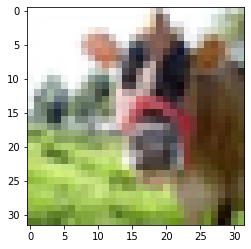

In [7]:
plt.imshow(train_images[0])

In [8]:
train_labels[0]

array([19])

In [9]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [10]:
import json

with open('/content/gdrive/MyDrive/cifar100_fine_labels.json', 'r') as fine_labels:
    cifar100_fine_labels = json.load(fine_labels)

In [11]:
len(cifar100_fine_labels)

100

# Modelling

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

In [13]:
def get_sequential_model():

  model = Sequential([
                      Dense(32, activation = 'relu', input_shape = (32, 32, 3)),
                      Dropout(0.5),
                      BatchNormalization(momentum=0.8),
                      Dense(16, activation = 'relu'),
                      Dropout(0.5),
                      Dense(1, activation = 'sigmoid')
  ])

  return model;

In [14]:
model = get_sequential_model()
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['acc', 'val_acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32, 32, 32)        128       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
dense_1 (Dense)              (None, 32, 32, 16)        528       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 16)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 32, 32, 1)         17        
Total params: 801
Trainable params: 737
Non-trainable params: 64
_________________________________________________________

In [15]:
num_classes = 100

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)
train_labels

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [16]:
def get_generator(features, labels, batch_size = 1):
  for n in range(features.shape[0]//batch_size):
    yield (features[n*batch_size: (n+1)*batch_size], labels[n*batch_size: (n+1)*batch_size])

In [17]:
train_generator = get_generator(train_images, train_labels, batch_size = 10)